In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from fitting.utils import get_lab_example
from data.data_generator import ConcatSessionsGenerator
from fitting.utils import get_data_generator_inputs, get_best_model_version
import pickle
import pandas as pd
from shutil import copyfile
import os
from behavenet.models import AE as AE
import torch
import scipy

In [3]:
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

FONT_SIZE = 18
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': FONT_SIZE})
#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Myriad Pro']
plt.rcParams["font.family"] = "Times New Roman"



plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title

In [4]:
def plot_sampled_latents(lab,training_data, x_smpls, ax, lw=0.4):
    T, D = training_data.shape

    # Compute mean and std of sampels
    x_smpl_mean = np.mean(x_smpls, axis=0)
    x_smpl_std = np.std(x_smpls, axis=0)
    spc = 1.1 * abs(training_data.max())


    for d in range(D):
        h = ax.plot(x_smpls[0][:, d] + spc * d, lw=lw)[0]

        if len(x_smpls) < 10:
            i_plot = np.arange(len(x_smpls))
        else:
            i_plot = np.random.choice(len(x_smpls), size=10, replace=False)

        for i in i_plot:
            ax.plot(x_smpls[i][:, d] + spc * d, color=h.get_color(), lw=lw)

        # Plot standard deviation of samples
#         ax.fill_between(np.arange(T),
#                          x_smpl_mean[:, d] - 2 * x_smpl_std[:, d] - spc * d,
#                          x_smpl_mean[:, d] + 2 * x_smpl_std[:, d] - spc * d,
#                          color=h.get_color(), alpha=0.25)

        # Plot sample mean
        # plt.plot(x_smpl_mean[:, d] - 5 * d, color=h.get_color(), lw=2)

        ax.plot(training_data[:, d] + spc * d, '-k', alpha=0.5)
                 # label="data" if d==0 else None)

    #ax.legend(loc="lower right")

    #ax.set_xlabel("Frame Number")
    #axset_yticks(-np.arange(D) * spc, ["dim {}".format(i+1) for i in range(D)])
    yticks = spc * np.arange(D+1)
    ax.set_yticks(yticks[::2])
    ax.set_yticklabels(np.arange(D+1)[::2])
    ax.set_ylabel("Latent Dimension")
    ax.set_xlim([0,T])
    if lab=='musall':   
        ax.set_xticks([0,200,400])
        ax.set_xticklabels((np.asarray([0,200,400])/hparams['frame_rate']).astype('int'))
        ax.axvline(x=173,ymin=0,ymax=1,c="black",linewidth=3, clip_on=False)
        ax.axvline(x=173*2,ymin=0,ymax=1,c="black",linewidth=3, clip_on=False)
    else:
        ax.set_xticks([0,200,400,600,800])
        ax.set_xticklabels((np.asarray([0,200,400,600,800])/hparams['frame_rate']).astype('int'))
    # plt.savefig("decoded_latents.png")
   # return fig

In [5]:
basedir ='/Users/eleanorbatty/Documents/behavenet/cluster/results/'
labs = ['musall','steinmetz','steinmetz-face']
dataset_names = ['WFCI','NP','NP-zoom']
test_idx=4
K=10
kappa=0

In [6]:
all_decoded_images={}
all_orig_images={}
baseline_mse=[]
nonlinear_mse=[]
arhmm_dec_mse=[]
baseline_std=[]
nonlinear_std=[]
arhmm_dec_std=[]
for i_lab, lab in enumerate(labs):
    
    hparams={'n_arhmm_states':10,'kappa':0,'noise_type':'gaussian'}
    hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
    hparams['data_dir'] = '/Volumes/paninski-locker/data/'

    get_lab_example(hparams, lab)
    
    ## Load test outputs
    sess_dir = os.path.join(
                hparams['tt_save_path'], hparams['lab'], hparams['expt'],
                hparams['animal'], hparams['session'])
    results_dir = os.path.join(
        sess_dir, 'arhmm-decoding',
        '%02i_latents' % hparams['n_ae_latents'],
        '%02i_states' % hparams['n_arhmm_states'],
        '%.0e_kappa' % hparams['kappa'],
        hparams['noise_type'],
        'test_tube_data',
        'best','version_1')
    test_outputs = np.load(os.path.join(results_dir,'test_outputs.npz'))

    ## Images
    hparams_orig = pickle.load(open(os.path.join(results_dir,'meta_tags.pkl'),'rb'))
    
    hparams={}
    hparams['ae_model_path'] = basedir+hparams_orig['ae_model_path'].split('results/')[1]
    hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
    hparams['data_dir'] = '/Volumes/paninski-locker/data/'
    hparams['model_class']='ae'
    hparams['signals']='images'
    hparams['transforms']=None
    hparams['load_kwargs']=None
    hparams['device']='cpu'
    hparams['as_numpy']=True
    hparams['batch_load']=True
    hparams['rng_seed']=0
    get_lab_example(hparams, lab)
    
    hparams, signals, transforms, load_kwargs = get_data_generator_inputs(hparams)
    ids = {
        'lab': hparams['lab'],
        'expt': hparams['expt'],
        'animal': hparams['animal'],
        'session': hparams['session']}
    data_generator = ConcatSessionsGenerator(
        hparams['data_dir'], ids,
        signals=signals, transforms=transforms, load_kwargs=load_kwargs,
        device=hparams['device'], as_numpy=hparams['as_numpy'],
        batch_load=hparams['batch_load'], rng_seed=hparams['rng_seed'])

    ae_model_file = os.path.join(hparams['ae_model_path'],'best_val_model.pt')
    ae_arch = pickle.load(open(os.path.join(hparams['ae_model_path'],'meta_tags.pkl'),'rb'))
    ae_model = AE(ae_arch)
    ae_model.load_state_dict(torch.load(ae_model_file, map_location=lambda storage, loc: storage))
    ae_model.eval()
    
    print(test_outputs['latents'][test_idx].shape)
    decoded_images = ae_model.decoding(torch.tensor(np.mean(test_outputs['arhmm_dec_samples'],axis=1)[test_idx]).float(),None,None).cpu().detach().numpy()   
    if lab =='musall':
        decoded_images  = np.transpose(decoded_images,(0,1,3,2))
    all_decoded_images[lab] = np.concatenate([decoded_images[:,j] for j in range(decoded_images.shape[1])],axis=2)     
    
    print(data_generator.datasets[0][data_generator.batch_indxs[0]['test'][test_idx]]['images'][8:-8].shape)
    orig_images = data_generator.datasets[0][data_generator.batch_indxs[0]['test'][test_idx]]['images'][8:-8].cpu().detach().numpy()
    if lab =='musall':
        orig_images  = np.transpose(orig_images,(0,1,3,2))
    all_orig_images[lab] = np.concatenate([orig_images[:,j] for j in range(orig_images.shape[1])],axis=2)     
    
    baseline_mse.append(np.mean(test_outputs['test_mse_baseline']))
    nonlinear_mse.append(np.mean(test_outputs['test_mse_nonlinear']))
    arhmm_dec_mse.append(np.mean(test_outputs['test_mse']))
    baseline_std.append(np.std(test_outputs['test_mse_baseline']))
    nonlinear_std.append(np.std(test_outputs['test_mse_nonlinear']))
    arhmm_dec_std.append(np.std(test_outputs['test_mse']))
    
    print(data_generator.batch_indxs[0]['train'].shape)
    print(data_generator.batch_indxs[0]['val'].shape)
    print(data_generator.batch_indxs[0]['test'].shape)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/paninski-locker/analysis/behavenet/musall/vistrained/mSM30/10-Oct-2017/arhmm-decoding/16_latents/10_states/0e+00_kappa/gaussian/test_tube_data/best/version_1/test_outputs.npz'

In [ ]:
(1.39-0.71)/1.39

In [ ]:
(5.55-1.92)/5.55

In [ ]:
baseline_mse

In [ ]:
baseline_std

In [7]:
nonlinear_mse

[]

In [8]:
arhmm_dec_mse

[]

In [9]:
plt.imshow(all_orig_images['steinmetz'][50])

KeyError: 'steinmetz'

In [10]:
plt.imshow(all_decoded_images['steinmetz'][250])

KeyError: 'steinmetz'

In [11]:
# i_lab=0
# lab = labs[i_lab]

# hparams={'n_arhmm_states':10,'kappa':0,'noise_type':'gaussian'}
# hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
# hparams['data_dir'] = '/Volumes/paninski-locker/data/'

# get_lab_example(hparams, lab)

# ## Load test outputs
# sess_dir = os.path.join(
#             hparams['tt_save_path'], hparams['lab'], hparams['expt'],
#             hparams['animal'], hparams['session'])
# results_dir = os.path.join(
#     sess_dir, 'arhmm-decoding',
#     '%02i_latents' % hparams['n_ae_latents'],
#     '%02i_states' % hparams['n_arhmm_states'],
#     '%.0e_kappa' % hparams['kappa'],
#     hparams['noise_type'],
#     'test_tube_data',
#     'best','version_1')
# test_outputs = np.load(os.path.join(results_dir,'test_outputs.npz'))

# expected_z = [np.mean(test_outputs['expected_z_samples'][i],axis=0) for i in range(test_outputs['expected_z_samples'].shape[0])]

# fig, axes = plt.subplots(3,1,figsize=(20,10))
# axes[1].imshow(expected_z[test_idx].T,vmin=0,vmax=1,cmap='gray_r')
# axes[0].imshow(np.exp(test_outputs['state_log_predictions'][test_idx]).T,vmin=0,vmax=1,cmap='gray_r')
# plot_sampled_latents(test_outputs['latents'][test_idx],test_outputs['arhmm_dec_samples'][test_idx],axes[2])


In [12]:
# ## Supplementary figure

# test_idx=2

# fig = plt.figure(figsize=(20,12))
# gs = plt.GridSpec(3,2)

# for i_lab, lab in enumerate(labs):
    
#     hparams={'n_arhmm_states':10,'kappa':0,'noise_type':'gaussian'}
#     hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
#     hparams['data_dir'] = '/Volumes/paninski-locker/data/'

#     get_lab_example(hparams, lab)
    
#     ## Load test outputs
#     sess_dir = os.path.join(
#                 hparams['tt_save_path'], hparams['lab'], hparams['expt'],
#                 hparams['animal'], hparams['session'])
#     results_dir = os.path.join(
#         sess_dir, 'arhmm-decoding',
#         '%02i_latents' % hparams['n_ae_latents'],
#         '%02i_states' % hparams['n_arhmm_states'],
#         '%.0e_kappa' % hparams['kappa'],
#         hparams['noise_type'],
#         'test_tube_data',
#         'best','version_1')
#     test_outputs = np.load(os.path.join(results_dir,'test_outputs.npz'))

#     # FF decoding
#     ax =  plt.subplot(gs[i_lab, 0])
#     plot_sampled_latents(test_outputs['latents'][test_idx],[test_outputs['nonlinear_dec'][test_idx]],ax)   
#     ax.text(-.2,.5,dataset_names[i_lab],transform=ax.transAxes,horizontalalignment='center',fontsize=FONT_SIZE)

#     # ARHMM decoding
#     ax =  plt.subplot(gs[i_lab, 1])
#     plot_sampled_latents(test_outputs['latents'][test_idx],[test_outputs['arhmm_dec_samples'][test_idx][0]],ax)
#     ax.set_ylabel('')
    
    
# ax =  plt.subplot(gs[0, 0])
# ax.set_title('FF Decoder')
# ax =  plt.subplot(gs[0, 1])
# ax.set_title('ARHMM Decoder')

# ax =  plt.subplot(gs[2, 0])
# ax.set_xlabel('Time (s)')
# ax =  plt.subplot(gs[2, 1])
# ax.set_xlabel('Time (s)')

# fig.savefig('../behavenet_figs/supp_fig_K_'+str(hparams['n_arhmm_states'])+'.pdf', transparent=True,bbox_inches='tight')



In [13]:
test_outputs['arhmm_dec_samples'][test_idx].shape

NameError: name 'test_outputs' is not defined

In [14]:
fig_overview = plt.figure(figsize=(24,24))

gs_traces = plt.GridSpec(3,2,bottom=0.45, width_ratios=[0.25,.75])

gs_images = plt.GridSpec(2,3,top=0.4,width_ratios=[0.42,0.40,0.22],wspace=0.05)

for i_lab, lab in enumerate(labs):
    
    hparams={'n_arhmm_states':10,'kappa':0,'noise_type':'gaussian'}
    hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
    hparams['data_dir'] = '/Volumes/paninski-locker/data/'

    get_lab_example(hparams, lab)
    
    ## Load test outputs
    sess_dir = os.path.join(
                hparams['tt_save_path'], hparams['lab'], hparams['expt'],
                hparams['animal'], hparams['session'])
    results_dir = os.path.join(
        sess_dir, 'arhmm-decoding',
        '%02i_latents' % hparams['n_ae_latents'],
        '%02i_states' % hparams['n_arhmm_states'],
        '%.0e_kappa' % hparams['kappa'],
        hparams['noise_type'],
        'test_tube_data',
        'best','version_1')
    test_outputs = np.load(os.path.join(results_dir,'test_outputs.npz'))

    ax_traces = plt.subplot(gs_traces[i_lab, 1])
    if lab == 'musall':
        plot_latents = np.concatenate((test_outputs['latents'][test_idx],test_outputs['latents'][test_idx+1],test_outputs['latents'][test_idx+2]),axis=0)
        plot_samples = np.concatenate((test_outputs['arhmm_dec_samples'][test_idx],test_outputs['arhmm_dec_samples'][test_idx+1],test_outputs['arhmm_dec_samples'][test_idx+2]),axis=1)  
    else:
        plot_latents = test_outputs['latents'][test_idx]
        plot_samples = test_outputs['arhmm_dec_samples'][test_idx]
        
    plot_sampled_latents(lab,plot_latents,plot_samples,ax_traces)
    if i_lab==len(labs)-1:
        ax_traces.set_xlabel('Time (s)')

    sample_idx=150
    ax_orig_image = plt.subplot(gs_images[0,i_lab])
    ax_orig_image.imshow(all_orig_images[lab][sample_idx],vmin=0,vmax=1,cmap='gray')
    ax_orig_image.set_xticks([])
    ax_orig_image.set_yticks([])
    [s.set_visible(False) for s in ax_orig_image.spines.values()]
    ax_orig_image.set_title(dataset_names[i_lab])
    
    ax_decoded_image = plt.subplot(gs_images[1,i_lab])
    ax_decoded_image.imshow(all_decoded_images[lab][sample_idx],vmin=0,vmax=1,cmap='gray')
    ax_decoded_image.set_xticks([])
    ax_decoded_image.set_yticks([])
    [s.set_visible(False) for s in ax_decoded_image.spines.values()]

    if i_lab==0:
        ax_orig_image.set_ylabel('Original')
        ax_decoded_image.set_ylabel('ARHMM-Decoded')
        
    ## Confusion matrices 
    prob_preds= np.exp(np.concatenate(test_outputs['state_log_predictions']))
    preds= np.argmax(np.exp(np.concatenate(test_outputs['state_log_predictions'])),axis=1)
    acts = np.concatenate(test_outputs['states'])

    print(scipy.stats.mode(acts))
    print(np.sum(acts==preds)/acts.shape[0])
    print(np.sum(acts==0)/acts.shape[0])

#     expected_z = [np.mean(test_outputs['expected_z_samples'][i],axis=0) for i in range(test_outputs['expected_z_samples'].shape[0])]
#     preds= np.argmax(np.concatenate(expected_z,axis=0),axis=1)
#     acts = np.concatenate(test_outputs['states'])

#     print(np.sum(acts==preds)/acts.shape[0])
#     print(np.sum(acts==0)/acts.shape[0])

    
    confusion_matrix = np.zeros((hparams['n_arhmm_states'],hparams['n_arhmm_states']))
    confusion_matrix[:]=np.nan
    
    for i_state in range(hparams['n_arhmm_states']):
        if np.sum(acts==i_state)>0:
            confusion_matrix[i_state] = np.mean(prob_preds[acts==i_state],axis=0)

    where_nans = np.unique(np.where(np.isnan(confusion_matrix))[0])
    
    confusion_matrix = np.delete(confusion_matrix,where_nans,axis=0)
    confusion_matrix = np.delete(confusion_matrix,where_nans,axis=1)
    ax1 = plt.subplot(gs_traces[i_lab,0])
    im = ax1.imshow(confusion_matrix,vmin=0,vmax=1,cmap='gray_r')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_ylabel('Actual States')
    ax1.set_xlabel('Predicted States')
    #ax1.set_title(dataset_names[i_lab])
    plt.colorbar(im,ax=ax1)
#     if i_lab==len(labs)-1:
#         ax1 = plt.subplot(gs_traces[i_lab,1])
#         ax1.axis('Off')
#         fig_overview.colorbar(im,ax=ax1)
    #[s.set_visible(False) for s in ax1.spines.values()] 
    
    ##    
    ax1.text(-.2,.5,dataset_names[i_lab],transform=ax1.transAxes,horizontalalignment='center',fontsize=FONT_SIZE)
   
#ax = plt.subplot(gs_mse[0, 0])
# inds = np.asarray([0,1,2])
# width=.25
# ax.bar(inds,baseline_mse, width=width, color='k',yerr=baseline_std)
# ax.bar(inds+width,nonlinear_mse, width=width, color='#2F4F4F',yerr=nonlinear_std)
# ax.bar(inds+2*width,arhmm_dec_mse, width=width, color='#A9A9A9',yerr=arhmm_dec_std)

# ax.set_xticks(inds+1.5*width)
# ax.set_xticklabels(dataset_names)

# ax.set_ylabel('Latent \n Prediction MSE')

# ax.legend(['Baseline','Nonlinear \n Decoding','ARHMM \n Decoding'],loc='center left', bbox_to_anchor=(1, 0.5))
#fig_overview.savefig('../behavenet_figs/decoding_K_'+str(hparams['n_arhmm_states'])+'.pdf', transparent=True,bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/paninski-locker/analysis/behavenet/musall/vistrained/mSM30/10-Oct-2017/arhmm-decoding/16_latents/10_states/0e+00_kappa/gaussian/test_tube_data/best/version_1/test_outputs.npz'

<Figure size 1728x1728 with 0 Axes>

In [ ]:
# fig_overview = plt.figure(figsize=(24,32))
# gs_matrices = plt.GridSpec(1,4,bottom=0.72,right=0.57,width_ratios=[0.31,0.31,0.31,.06])
# gs_mse = plt.GridSpec(1,1,bottom=0.72,left=0.6,right=0.8)


# gs_traces = plt.GridSpec(3,1,top=0.70,bottom=0.3,left=0.2)
# gs_images = plt.GridSpec(2,3,top=0.25,width_ratios=[0.42,0.40,0.22],wspace=0.05)

# for i_lab, lab in enumerate(labs):
    
#     hparams={'n_arhmm_states':10,'kappa':0,'noise_type':'gaussian'}
#     hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
#     hparams['data_dir'] = '/Volumes/paninski-locker/data/'

#     get_lab_example(hparams, lab)
    
#     ## Load test outputs
#     sess_dir = os.path.join(
#                 hparams['tt_save_path'], hparams['lab'], hparams['expt'],
#                 hparams['animal'], hparams['session'])
#     results_dir = os.path.join(
#         sess_dir, 'arhmm-decoding',
#         '%02i_latents' % hparams['n_ae_latents'],
#         '%02i_states' % hparams['n_arhmm_states'],
#         '%.0e_kappa' % hparams['kappa'],
#         hparams['noise_type'],
#         'test_tube_data',
#         'best','version_1')
#     test_outputs = np.load(os.path.join(results_dir,'test_outputs.npz'))

#     ax_traces = plt.subplot(gs_traces[i_lab, 0])
    
#     plot_sampled_latents(test_outputs['latents'][test_idx],test_outputs['arhmm_dec_samples'][test_idx],ax_traces)
#     if i_lab==len(labs)-1:
#         ax_traces.set_xlabel('Time (s)')

#     sample_idx=150
#     ax_orig_image = plt.subplot(gs_images[0,i_lab])
#     ax_orig_image.imshow(all_orig_images[lab][sample_idx],vmin=0,vmax=1,cmap='gray')
#     ax_orig_image.set_xticks([])
#     ax_orig_image.set_yticks([])
#     [s.set_visible(False) for s in ax_orig_image.spines.values()]
#     ax_orig_image.set_title(dataset_names[i_lab])
    
#     ax_decoded_image = plt.subplot(gs_images[1,i_lab])
#     ax_decoded_image.imshow(all_decoded_images[lab][sample_idx],vmin=0,vmax=1,cmap='gray')
#     ax_decoded_image.set_xticks([])
#     ax_decoded_image.set_yticks([])
#     [s.set_visible(False) for s in ax_decoded_image.spines.values()]

#     if i_lab==0:
#         ax_orig_image.set_ylabel('Original')
#         ax_decoded_image.set_ylabel('ARHMM-Decoded')
        
#     ## Confusion matrices 
#     prob_preds= np.exp(np.concatenate(test_outputs['state_log_predictions']))
#     preds= np.argmax(np.exp(np.concatenate(test_outputs['state_log_predictions'])),axis=1)
#     acts = np.concatenate(test_outputs['states'])

    
#     print(np.sum(acts==preds)/acts.shape[0])
#     print(np.sum(acts==0)/acts.shape[0])

#     expected_z = [np.mean(test_outputs['expected_z_samples'][i],axis=0) for i in range(test_outputs['expected_z_samples'].shape[0])]
#     preds= np.argmax(np.concatenate(expected_z,axis=0),axis=1)
#     acts = np.concatenate(test_outputs['states'])

#     print(np.sum(acts==preds)/acts.shape[0])
#     print(np.sum(acts==0)/acts.shape[0])

    
#     confusion_matrix = np.zeros((hparams['n_arhmm_states'],hparams['n_arhmm_states']))
#     confusion_matrix[:]=np.nan
    
#     for i_state in range(hparams['n_arhmm_states']):
#         if np.sum(acts==i_state)>0:
#             confusion_matrix[i_state] = np.mean(prob_preds[acts==i_state],axis=0)

#     where_nans = np.unique(np.where(np.isnan(confusion_matrix))[0])
    
#     confusion_matrix = np.delete(confusion_matrix,where_nans,axis=0)
#     confusion_matrix = np.delete(confusion_matrix,where_nans,axis=1)
#     ax1 = plt.subplot(gs_matrices[0,i_lab])
#     im = ax1.imshow(confusion_matrix,vmin=0,vmax=1,cmap='gray_r')
#     ax1.set_xticks([])
#     ax1.set_yticks([])
#     ax1.set_ylabel('Actual States')
#     ax1.set_xlabel('Predicted States')
#     ax1.set_title(dataset_names[i_lab])
#     if i_lab==len(labs)-1:
#         ax1 = plt.subplot(gs_matrices[0,i_lab+1])
#         ax1.axis('Off')
#         fig_overview.colorbar(im,ax=ax1)
#     #[s.set_visible(False) for s in ax1.spines.values()] 
    
#     ##    
#     ax_traces.text(-.1,.5,dataset_names[i_lab],transform=ax_traces.transAxes,horizontalalignment='center',fontsize=FONT_SIZE)
   
# ax = plt.subplot(gs_mse[0, 0])

# inds = np.asarray([0,1,2])
# width=.25
# ax.bar(inds,baseline_mse, width=width, color='k',yerr=baseline_std)
# ax.bar(inds+width,nonlinear_mse, width=width, color='#2F4F4F',yerr=nonlinear_std)
# ax.bar(inds+2*width,arhmm_dec_mse, width=width, color='#A9A9A9',yerr=arhmm_dec_std)

# ax.set_xticks(inds+1.5*width)
# ax.set_xticklabels(dataset_names)

# ax.set_ylabel('Latent \n Prediction MSE')

# ax.legend(['Baseline','Nonlinear \n Decoding','ARHMM \n Decoding'],loc='center left', bbox_to_anchor=(1, 0.5))
# fig_overview.savefig('../behavenet_figs/decoding_K_'+str(hparams['n_arhmm_states'])+'.pdf', transparent=True,bbox_inches='tight')


In [41]:
def make_real_vs_decoded_movies(filepath, hparams, real_latents, arhmm_decoded_latents, data_generator, trial_idxs, n_buffer=5):

    n_ae_latents = real_latents[0].shape[1]
    mean_decoded_latents = np.mean(arhmm_decoded_latents,axis=1)
    latents_ae_color = [0.2, 0.2, 0.2]
    latents_dec_color = [0, 0, 0]
    im_kwargs = {'animated': True, 'cmap': 'gray', 'vmin': 0, 'vmax': 1}
    tr_kwargs = {'animated': True, 'linewidth': 2}
    fontsize = 12
    plot_n_frames = hparams['plot_n_frames']
    if hparams['plot_frame_rate'] == 'orig':
        raise NotImplementedError
    else:
        plot_frame_rate = hparams['plot_frame_rate']

    n_latents = hparams['n_ae_latents']
    [bs, n_channels, y_dim, x_dim] = data_generator.datasets[0][0]['images'].shape


    ## Load in AE decoder
    ae_model_file = os.path.join(hparams['ae_model_path'],'best_val_model.pt')
    ae_arch = pickle.load(open(os.path.join(hparams['ae_model_path'],'meta_tags.pkl'),'rb'))
    ae_model = AE(ae_arch)
    ae_model.load_state_dict(torch.load(ae_model_file, map_location=lambda storage, loc: storage))
    ae_model.eval()


    # Make original videos vs real recons vs simulated recons arrays
    #which_trials = np.arange(0,len(real_latents)).astype('int')
    #np.random.shuffle(which_trials)

    #which_trials = np.arange(0,len(real_latents)).astype('int')
    #np.random.shuffle(which_trials)  
    which_trials = [13]
    all_orig = np.zeros((0,n_channels*y_dim,x_dim))
    i_trial=0
    while all_orig.shape[0] < plot_n_frames:

        orig = data_generator.datasets[0][trial_idxs[which_trials[i_trial]]]['images'][8:-8].cpu().detach().numpy()
        #recon = ae_model.decoding(torch.tensor(latents[which_trials[i_trial]]).float(), None, None).cpu().detach().numpy()
        if hparams['lab']=='musall':
            orig = np.transpose(orig,(0,1,3,2))
        orig = np.concatenate([orig[:,i] for i in range(orig.shape[1])],axis=1)

        # Add a few black frames
        zero_frames = np.zeros((n_buffer,n_channels*y_dim,x_dim))

        all_orig = np.concatenate((all_orig,orig,zero_frames),axis=0)
        i_trial+=1


    all_recon = np.zeros((0,n_channels*y_dim,x_dim))
    i_trial=0
    while all_recon.shape[0] < plot_n_frames:

        recon = ae_model.decoding(torch.tensor(real_latents[which_trials[i_trial]]).float(), None, None).cpu().detach().numpy()
        if hparams['lab']=='musall':
            recon = np.transpose(recon,(0,1,3,2))
        recon = np.concatenate([recon[:,i] for i in range(recon.shape[1])],axis=1)

        # Add a few black frames
        zero_frames = np.zeros((n_buffer,n_channels*y_dim,x_dim))

        all_recon = np.concatenate((all_recon,recon,zero_frames),axis=0)
        i_trial+=1


#     all_nonlinear_decoded_recon = np.zeros((0,n_channels*y_dim,x_dim))
#     i_trial=0
#     while all_nonlinear_decoded_recon.shape[0] < plot_n_frames:

#         nonlinear_decoded_recon = ae_model.decoding(torch.tensor(nonlinear_decoded_latents[i_trial]).float(), None, None).cpu().detach().numpy()
#         if hparams['lab']=='musall':
#             nonlinear_decoded_recon = np.transpose(nonlinear_decoded_recon,(0,1,3,2))
#         nonlinear_decoded_recon = np.concatenate([nonlinear_decoded_recon[:,i] for i in range(nonlinear_decoded_recon.shape[1])],axis=1)

#         # Add a few black frames
#         zero_frames = np.zeros((n_buffer,n_channels*y_dim,x_dim))

#         all_nonlinear_decoded_recon = np.concatenate((all_nonlinear_decoded_recon,nonlinear_decoded_recon,zero_frames),axis=0)
#         i_trial+=1

    all_arhmm_decoded_recon = np.zeros((0,n_channels*y_dim,x_dim))
    i_trial=0
    while all_arhmm_decoded_recon.shape[0] < plot_n_frames:

        arhmm_decoded_recon = ae_model.decoding(torch.tensor(mean_decoded_latents[which_trials[i_trial]]).float(), None, None).cpu().detach().numpy()
        if hparams['lab']=='musall':
            arhmm_decoded_recon = np.transpose(arhmm_decoded_recon,(0,1,3,2))
        arhmm_decoded_recon = np.concatenate([arhmm_decoded_recon[:,i] for i in range(arhmm_decoded_recon.shape[1])],axis=1)

        # Add a few black frames
        zero_frames = np.zeros((n_buffer,n_channels*y_dim,x_dim))

        all_arhmm_decoded_recon = np.concatenate((all_arhmm_decoded_recon,arhmm_decoded_recon,zero_frames),axis=0)
        i_trial+=1
        
    # Make videos
    plt.clf()
    fig_dim_div = x_dim*3/10 # aiming for dim 1 being 10
    fig_overview = plt.figure(figsize=(x_dim*4/fig_dim_div,2*y_dim*n_channels/fig_dim_div+2))
    #fig, axes = plt.subplots(1,3,figsize=(x_dim*4/fig_dim_div,y_dim*n_channels/fig_dim_div+2))
    gs = plt.GridSpec(2,3)
    

    axes = [fig_overview.add_subplot(gs[0,0]),fig_overview.add_subplot(gs[0,1]),fig_overview.add_subplot(gs[0,2]),fig_overview.add_subplot(gs[1,:])]
    
    for j in range(3):
        axes[j].set_xticks([])
        axes[j].set_yticks([])

    axes[0].set_title('Original Frames',fontsize=14)
    axes[1].set_title('Real Reconstructions',fontsize=14)
    #axes[2].set_title('Nonlinear Decoded \n Reconstructions',fontsize=14)
    axes[2].set_title('ARHMM Decoded \n Reconstructions',fontsize=14)
    fig_overview.tight_layout(pad=0)
    spc =  1.1 * abs(real_latents[which_trials[0]]).max()
    ims = []
    i_trial=0
    for i in range(plot_n_frames):
        print(i)
        ims_curr = []

        im = axes[0].imshow(all_orig[i],cmap='gray',vmin=0,vmax=1,animated=True)
        ims_curr.append(im)

        im = axes[1].imshow(all_recon[i],cmap='gray',vmin=0,vmax=1,animated=True)
        ims_curr.append(im)

#         im = axes[2].imshow(all_nonlinear_decoded_recon[i],cmap='gray',vmin=0,vmax=1,animated=True)
#         ims_curr.append(im)
        
        im = axes[2].imshow(all_arhmm_decoded_recon[i],cmap='gray',vmin=0,vmax=1,animated=True)
        ims_curr.append(im)
        time = np.arange(all_orig.shape[0]+1)
        #ims.append(ims_curr)
        indx=3
        for l in range(n_ae_latents):
            # just put labels on last lvs
            if l == n_ae_latents - 1 and i == 0:
                label_ae = 'AE latents'
                label_dec = 'Predicted AE latents'
            else:
                label_ae = None
                label_dec = None
            im = axes[indx].plot(
                time[0:i + 1], spc*l + real_latents[which_trials[i_trial]][0:i + 1, l],
                color=latents_ae_color, alpha=0.7, label=label_ae,
                **tr_kwargs)[0]
            axes[indx].spines['top'].set_visible(False);
            axes[indx].spines['right'].set_visible(False);
            axes[indx].spines['left'].set_visible(False)
            ims_curr.append(im)
            im = axes[indx].plot(
                time[0:i + 1], spc*l + arhmm_decoded_latents[which_trials[i_trial]][0][0:i + 1, l],
                color=latents_dec_color, label=label_dec, **tr_kwargs)[0]
            axes[indx].spines['top'].set_visible(False);
            axes[indx].spines['right'].set_visible(False);
            axes[indx].spines['left'].set_visible(False)
            plt.legend(
                loc='lower right', fontsize=fontsize, frameon=True,
                framealpha=0.7, edgecolor=[1, 1, 1])
            ims_curr.append(im)
        ims.append(ims_curr)
    ani = animation.ArtistAnimation(fig_overview, ims, interval=20, blit=True, repeat=False)
    writer = FFMpegWriter(fps=plot_frame_rate, metadata=dict(artist='mrw'))
    save_file = os.path.join(filepath,hparams['dataset_name']+'_real_vs_decoded_K_'+str(hparams['n_arhmm_states'])+'_kappa_'+str(hparams['kappa'])+'_noise_'+hparams['noise_type']+'.mp4')
    ani.save(save_file, writer=writer)

musall


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


<Figure size 432x288 with 0 Axes>

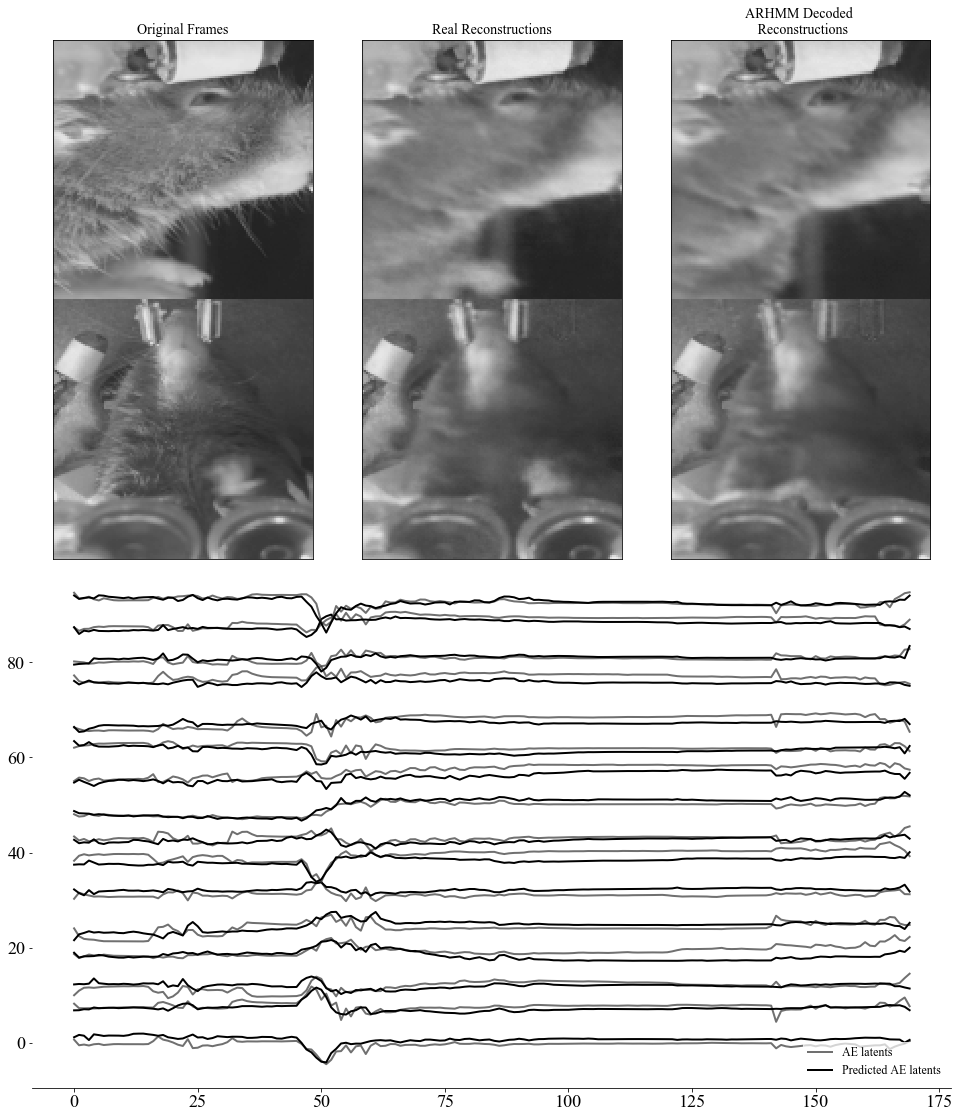

In [42]:

import matplotlib
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
## Make decoding videos
labs = ['musall']
dataset_names = ['NP','NP-zoom']
for i_lab, lab in enumerate(labs):
    print(lab)
    hparams={'n_arhmm_states':10,'kappa':0,'noise_type':'gaussian'}
    hparams['tt_save_path']='/Users/eleanorbatty/Documents/behavenet/cluster/results/'
    hparams['data_dir'] = '/Users/eleanorbatty/Documents/behavenet/cluster/data/'

    get_lab_example(hparams, lab)
    
    ## Load test outputs
    sess_dir = os.path.join(
                hparams['tt_save_path'], hparams['lab'], hparams['expt'],
                hparams['animal'], hparams['session'])
    results_dir = os.path.join(
        sess_dir, 'arhmm-decoding',
        '%02i_latents' % hparams['n_ae_latents'],
        '%02i_states' % hparams['n_arhmm_states'],
        '%.0e_kappa' % hparams['kappa'],
        hparams['noise_type'],
        'test_tube_data',
        'best','version_1')
    test_outputs = np.load(os.path.join(results_dir,'test_outputs.npz'))

    ## Images
    hparams_orig = pickle.load(open(os.path.join(results_dir,'meta_tags.pkl'),'rb'))
    
    hparams={}
    hparams['ae_model_path'] = basedir+hparams_orig['ae_model_path'].split('results/')[1]
    hparams['tt_save_path']='/Users/eleanorbatty/Documents/behavenet/cluster/results/'
    hparams['data_dir'] =  '/Users/eleanorbatty/Documents/behavenet/cluster/data/'
    hparams['model_class']='ae'
    hparams['signals']='images'
    hparams['transforms']=None
    hparams['load_kwargs']=None
    hparams['device']='cpu'
    hparams['as_numpy']=True
    hparams['batch_load']=True
    hparams['rng_seed']=0
    hparams['plot_n_frames']=170
    hparams['plot_frame_rate']=7
    get_lab_example(hparams, lab)
    
    hparams, signals, transforms, load_kwargs = get_data_generator_inputs(hparams)
    ids = {
        'lab': hparams['lab'],
        'expt': hparams['expt'],
        'animal': hparams['animal'],
        'session': hparams['session']}
    data_generator = ConcatSessionsGenerator(
        hparams['data_dir'], ids,
        signals=signals, transforms=transforms, load_kwargs=load_kwargs,
        device=hparams['device'], as_numpy=hparams['as_numpy'],
        batch_load=hparams['batch_load'], rng_seed=hparams['rng_seed'])
    hparams['dataset_name']=dataset_names[i_lab]
    hparams['lab_example']=lab
    hparams['n_arhmm_states']=K
    hparams['kappa']=kappa
    hparams['noise_type']='gaussian'
    make_real_vs_decoded_movies('../behavenet_figs/', hparams, test_outputs['latents'], test_outputs['arhmm_dec_samples'], data_generator, data_generator.batch_indxs[0]['test'])
    



In [39]:
trial_idxs = data_generator.batch_indxs[0]['test']
which_trials=[13]
# could be 2, 8, 13 (most prob)
i_trial=0
orig = data_generator.datasets[0][trial_idxs[which_trials[i_trial]]]['images'][8:-8].cpu().detach().numpy()

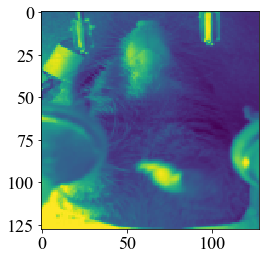

In [40]:
plt.imshow(orig[0,1].T)

In [91]:
np.mean(np.mean(test_outputs['latents'],axis=1),axis=0).shape

(12,)

In [99]:
ff = '/Users/eleanorbatty/Documents/behavenet/cluster/results/steinmetz/2-probe-face/mouse-01/session-01/neural-ae/12_latents/ff/test_tube_data/grid_search/version_294/predictions.pkl'

In [100]:
lats = pickle.load(open(ff,'rb'))

In [92]:
np.mean((np.mean(np.mean(test_outputs['latents'],axis=1),axis=0)-test_outputs['latents'])**2)

5.482084

In [101]:
data_generator.batch_indxs[0]['test']

array([ 32,  92,  52, 102,  22,  72,  82,  42,  12,  62])

In [104]:
lats['predictions'][0].shape

(1000, 12)

In [105]:
test_outputs['nonlinear_dec'][0].shape

(984, 12)

In [111]:
np.max(np.abs(test_outputs['nonlinear_dec'][2]-lats['predictions'][52][8:-8]))

0.0

In [84]:
np.mean((test_outputs['nonlinear_dec']-test_outputs['latents'])**2)

2.1210654

In [85]:
np.mean((np.mean(test_outputs['arhmm_dec_samples'],axis=1)-test_outputs['latents'])**2)

1.9208233598607953

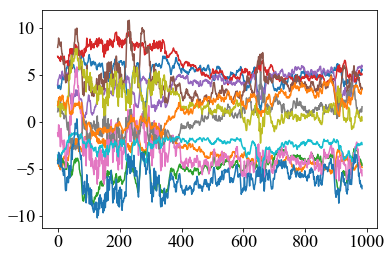

In [93]:
plt.plot(test_outputs['nonlinear_dec'][4]);

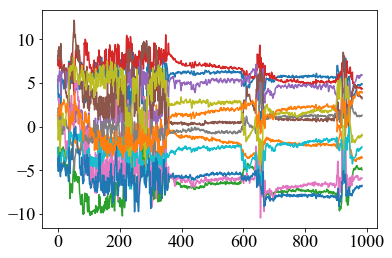

In [94]:
plt.plot(test_outputs['latents'][4]);

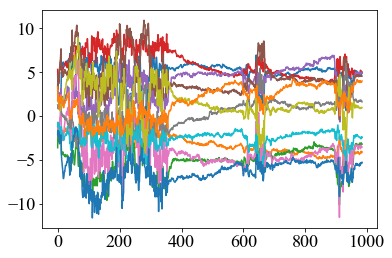

In [95]:
plt.plot(test_outputs['arhmm_dec_samples'][4][1]);

In [ ]:
#     ax2 = plt.subplot(gs[i_lab, 2])

#     comparisons = [np.mean(test_outputs['test_mse_baseline']),np.mean(test_outputs['test_mse_nonlinear']),np.mean(test_outputs['test_mse'])]
#     err = [np.std(test_outputs['test_mse_baseline']),np.std(test_outputs['test_mse_nonlinear']),np.std(test_outputs['test_mse'])]

#     barlist = ax2.bar([0,1,2],comparisons, width=.99, color='b',yerr=err)
#     barlist[0].set_color('k')
#     barlist[1].set_color('#2F4F4F')
#     barlist[2].set_color('#A9A9A9')
    
#     ax2.set_xticks([0,1,2])
#     if i_lab==len(labs)-1:
#         ax2.set_xticklabels(['Baseline','Nonlinear \n Decoding','ARHMM \n Decoding'],rotation=60)
#     else:
#         ax2.set_xticklabels([])
#     ax2.set_ylabel('Latent \n Prediction MSE')


In [ ]:
# fig_overview = plt.figure(figsize=(24,14))
# gs = plt.GridSpec(4,7,wspace=.6)

# labs = ['musall','steinmetz','steinmetz-face','datta']
# labs_capped = ['WFCI','NP','NP-zoom','Kinect']
 
# for i_lab, lab in enumerate(labs):
    
#     hparams={'n_arhmm_states':10,'kappa':0,'noise_type':'gaussian'}
#     hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
#     hparams['data_dir'] = '/Volumes/paninski-locker/data/'

#     get_lab_example(hparams, lab)
    
#     ## Load test outputs
#     sess_dir = os.path.join(
#                 hparams['tt_save_path'], hparams['lab'], hparams['expt'],
#                 hparams['animal'], hparams['session'])
#     results_dir = os.path.join(
#         sess_dir, 'arhmm-decoding',
#         '%02i_latents' % hparams['n_ae_latents'],
#         '%02i_states' % hparams['n_arhmm_states'],
#         '%.0e_kappa' % hparams['kappa'],
#         hparams['noise_type'],
#         'test_tube_data',
#         'best','version_1','test_outputs.npz')
#     test_outputs = np.load(results_dir)
    
#     ## Plot confusion matrix
#     prob_preds= np.exp(np.concatenate(test_outputs['state_log_predictions']))
#     preds= np.argmax(np.exp(np.concatenate(test_outputs['state_log_predictions'])),axis=1)
#     acts = np.concatenate(test_outputs['states'])

#     print(np.sum(acts==preds)/acts.shape[0])
#     print(np.sum(acts==0)/acts.shape[0])

#     confusion_matrix = np.zeros((hparams['n_arhmm_states'],hparams['n_arhmm_states']))

#     for i_state in range(hparams['n_arhmm_states']):
#         confusion_matrix[i_state] = np.mean(prob_preds[acts==i_state],axis=0)

#     ax1 = plt.subplot(gs[i_lab, 0:2])
#     im = ax1.imshow(confusion_matrix)
#     ax1.set_xticks([])
#     ax1.set_yticks([])
#     ax1.set_ylabel('Actual States')
#     ax1.set_xlabel('Predicted States')
#     plt.colorbar(im,ax=ax1)
#     #[s.set_visible(False) for s in ax1.spines.values()] 

#     ax2 = plt.subplot(gs[i_lab, 2])

#     comparisons = [np.mean(test_outputs['test_mse_baseline']),np.mean(test_outputs['test_mse_nonlinear']),np.mean(test_outputs['test_mse'])]
#     err = [np.std(test_outputs['test_mse_baseline']),np.std(test_outputs['test_mse_nonlinear']),np.std(test_outputs['test_mse'])]

#     barlist = ax2.bar([0,1,2],comparisons, width=.99, color='b',yerr=err)
#     barlist[0].set_color('k')
#     barlist[1].set_color('#2F4F4F')
#     barlist[2].set_color('#A9A9A9')
    
#     ax2.set_xticks([0,1,2])
#     if i_lab==len(labs)-1:
#         ax2.set_xticklabels(['Baseline','Nonlinear \n Decoding','ARHMM \n Decoding'],rotation=60)
#     else:
#         ax2.set_xticklabels([])
#     ax2.set_ylabel('Latent \n Prediction MSE')

#     ax3 = plt.subplot(gs[i_lab, 3:])
#     test_idx=4
#     plot_sampled_latents(test_outputs['latents'][test_idx],test_outputs['arhmm_dec_samples'][test_idx],ax3)
#     if i_lab==len(labs)-1:
#         ax3.set_xlabel('Frame Number')

#     ax1.text(-.4,.5,labs_capped[i_lab],transform=ax1.transAxes,horizontalalignment='center',fontsize=FONT_SIZE)
    
# fig_overview.savefig('../behavenet_figs/decoding2.pdf', transparent=True,bbox_inches='tight')

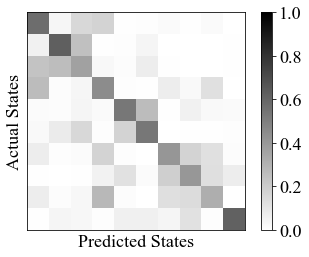

In [21]:
lab='musall'
hparams={'n_arhmm_states':10,'kappa':0,'noise_type':'gaussian'}
hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
hparams['data_dir'] = '/Volumes/paninski-locker/data/'

get_lab_example(hparams, lab)

## Load test outputs
sess_dir = os.path.join(
            hparams['tt_save_path'], hparams['lab'], hparams['expt'],
            hparams['animal'], hparams['session'])
results_dir = os.path.join(
    sess_dir, 'arhmm-decoding',
    '%02i_latents' % hparams['n_ae_latents'],
    '%02i_states' % hparams['n_arhmm_states'],
    '%.0e_kappa' % hparams['kappa'],
    hparams['noise_type'],
    'test_tube_data',
    'best','version_1')
test_outputs = np.load(os.path.join(results_dir,'test_outputs.npz'))

prob_preds= np.exp(np.concatenate(test_outputs['state_log_predictions']))
preds= np.argmax(np.exp(np.concatenate(test_outputs['state_log_predictions'])),axis=1)
acts = np.concatenate(test_outputs['states'])

hparams={'n_arhmm_states':10}
confusion_matrix = np.zeros((hparams['n_arhmm_states'],hparams['n_arhmm_states']))
confusion_matrix[:]=np.nan

for i_state in range(hparams['n_arhmm_states']):
    if np.sum(acts==i_state)>0:
        confusion_matrix[i_state] = np.mean(prob_preds[acts==i_state],axis=0)

where_nans = np.unique(np.where(np.isnan(confusion_matrix))[0])

confusion_matrix = np.delete(confusion_matrix,where_nans,axis=0)
confusion_matrix = np.delete(confusion_matrix,where_nans,axis=1)
ax1 = plt.subplot(1,1,1)
im = ax1.imshow(confusion_matrix,vmin=0,vmax=1,cmap='gray_r')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylabel('Actual States')
ax1.set_xlabel('Predicted States')
#ax1.set_title(dataset_names[i_lab])
plt.colorbar(im,ax=ax1)


In [37]:
np.sum(confusion_matrix[:,0])

1.3221270944923162

In [23]:
rr = np.asarray([[1,2,3],[4,5,6],[7,8,9]])

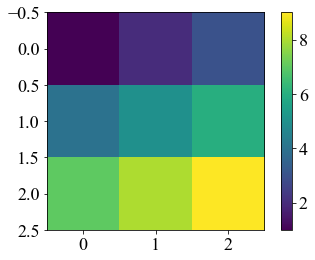

In [25]:
plt.imshow(rr)
plt.colorbar()

In [38]:
    lab='steinmetz-face'
    hparams={'n_arhmm_states':10,'kappa':0,'noise_type':'gaussian'}
    hparams['tt_save_path']='/Volumes/paninski-locker/analysis/behavenet/'
    hparams['data_dir'] = '/Volumes/paninski-locker/data/'

    get_lab_example(hparams, lab)
    
    ## Load test outputs
    sess_dir = os.path.join(
                hparams['tt_save_path'], hparams['lab'], hparams['expt'],
                hparams['animal'], hparams['session'])
    results_dir = os.path.join(
        sess_dir, 'arhmm-decoding',
        '%02i_latents' % hparams['n_ae_latents'],
        '%02i_states' % hparams['n_arhmm_states'],
        '%.0e_kappa' % hparams['kappa'],
        hparams['noise_type'],
        'test_tube_data',
        'best','version_1')
    test_outputs = np.load(os.path.join(results_dir,'test_outputs.npz'))


In [40]:
test_outputs['test_mse_baseline']

array([5.98319578, 5.1189003 , 4.34551144, 4.68130922, 9.23488426,
       3.55169463, 3.55285549, 3.65818119, 8.81730652, 6.62080479])